# NEW YORK AIR-BNB PRICE PREDICTION(2021)


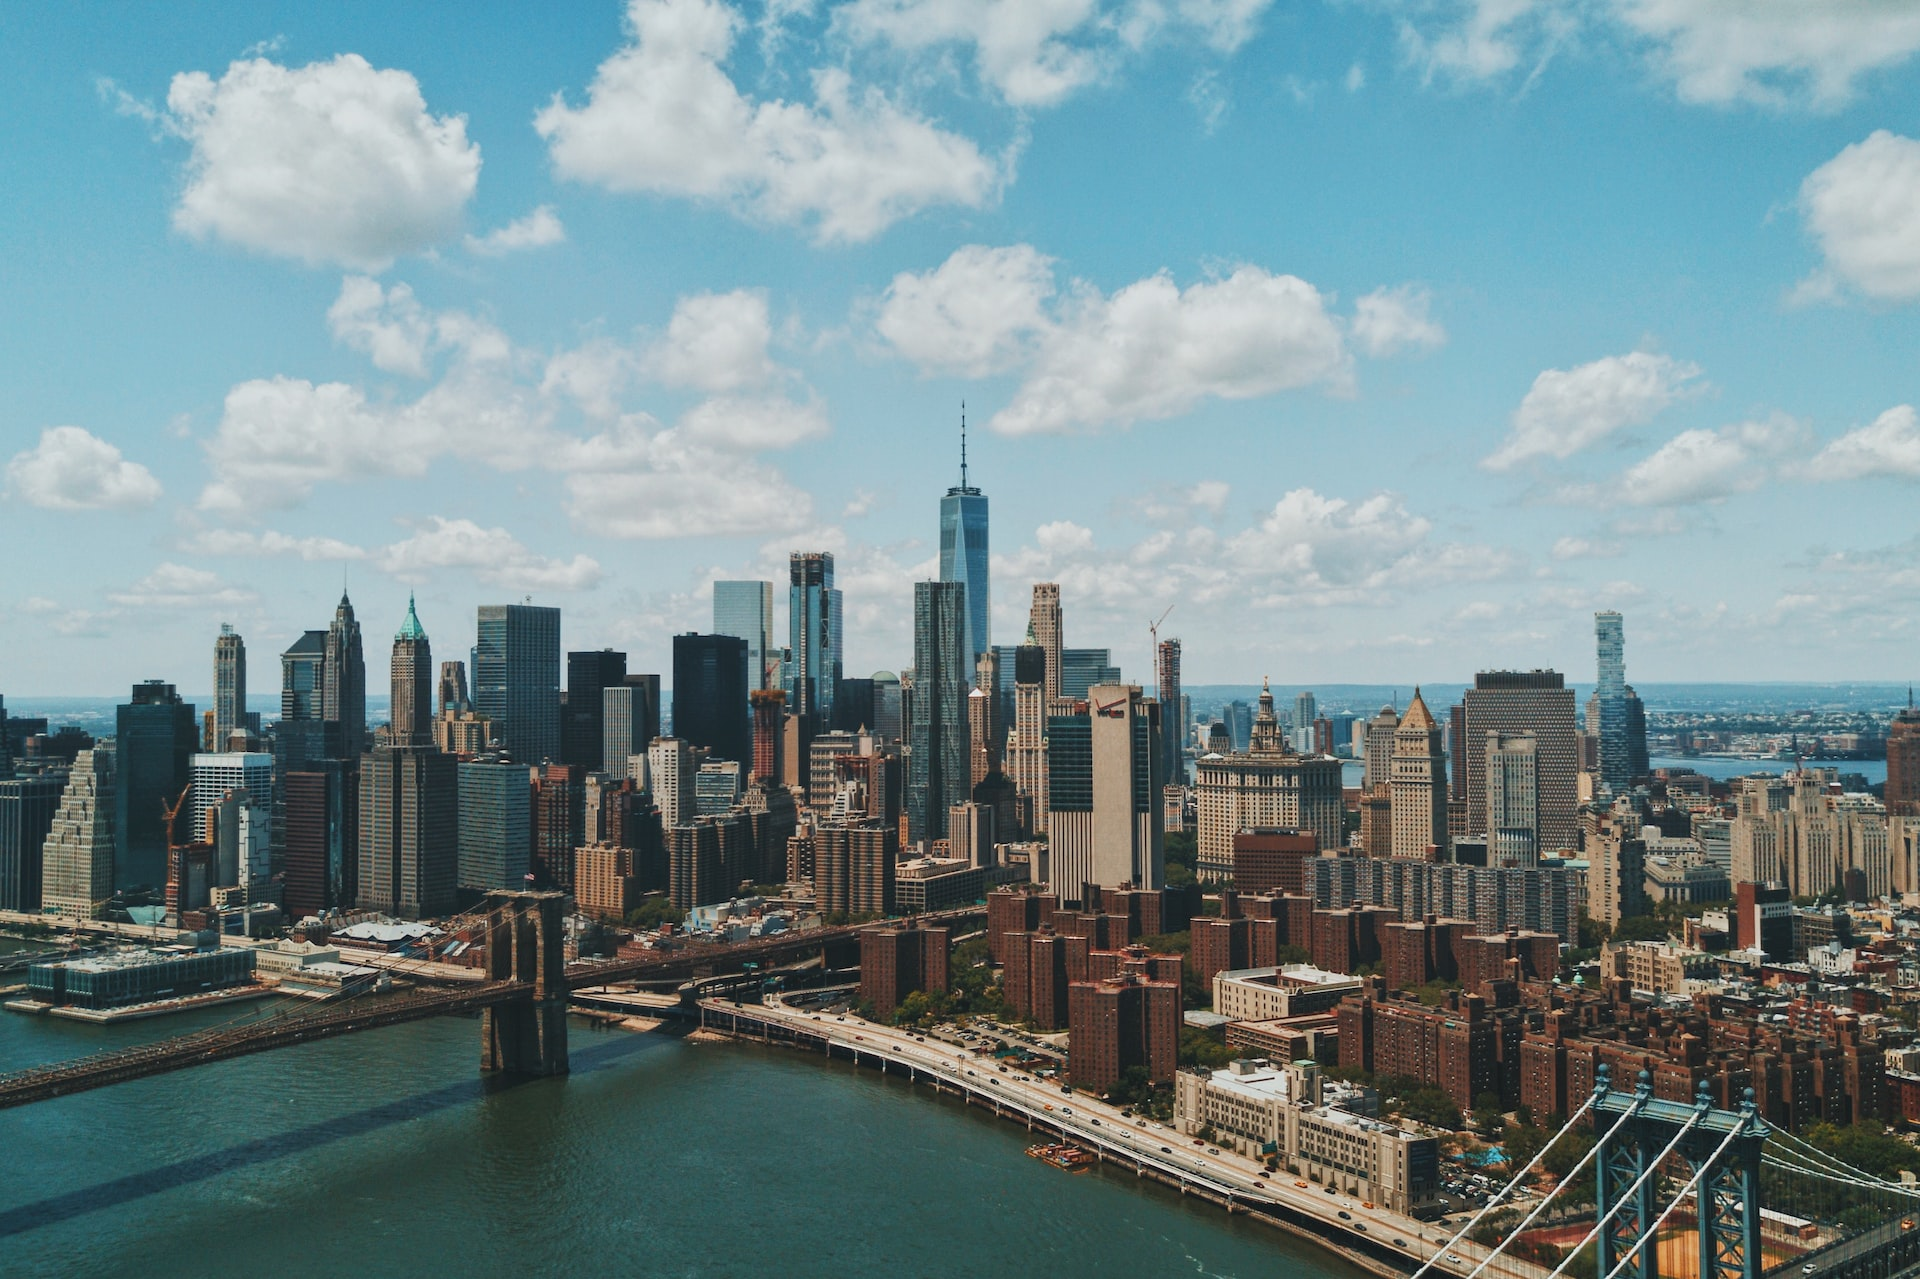

## INTRODUCTION :
Airbnb is an American company that operates an online marketplace for lodging, primarily homestays for vacation rentals, and tourism activities.
Based in San Francisco, California, the platform is accessible via website and mobile app. 
Airbnb does not own any of the listed properties; instead, it profits by receiving commission from each booking. 
The company was founded in 2008 by Brian Chesky, Nathan Blecharczyk and Joe Gebbia.
By October 2013, Airbnb had served 9,000,000 guests since its founding in August 2008.
Nearly 250,000 properties were added in 2013.
On December 10, 2020, the company became a public company via an initial public offering, raising $3.5 billion.

## IMPORTING LIBRARIES

In [ ]:
import numpy as np 
import math

#from copy import copy
import pandas as pd
from scipy.stats import boxcox
from scipy.special import boxcox1p
from scipy.special import inv_boxcox
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
#from IPython.display import Image

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor 

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#import folium
#from folium.plugins import HeatMap
#from folium.plugins import FastMarkerCluster
from scipy import stats
import statsmodels.api as sm

%matplotlib inline
sns.set_style("whitegrid")

## DATASET OVERVIEW

In [ ]:
df = pd.read_csv('AB_NYC_2021.csv')
print(df.head())

     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  19

In [ ]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [ ]:
print(df.info())
print("\n\n",df['neighbourhood'].value_counts())
print("\n\n",df['room_type'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

## EXPLORATORY DATA ANALYSIS

### CORRELATION MARTIX 

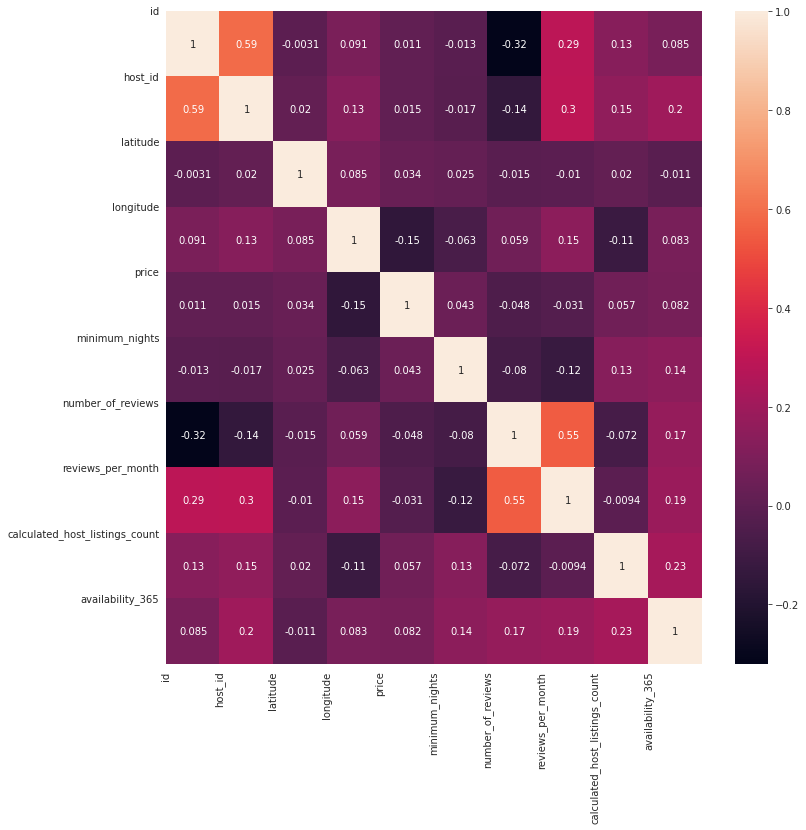

In [ ]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, annot=True)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

### PAIRPLOTS

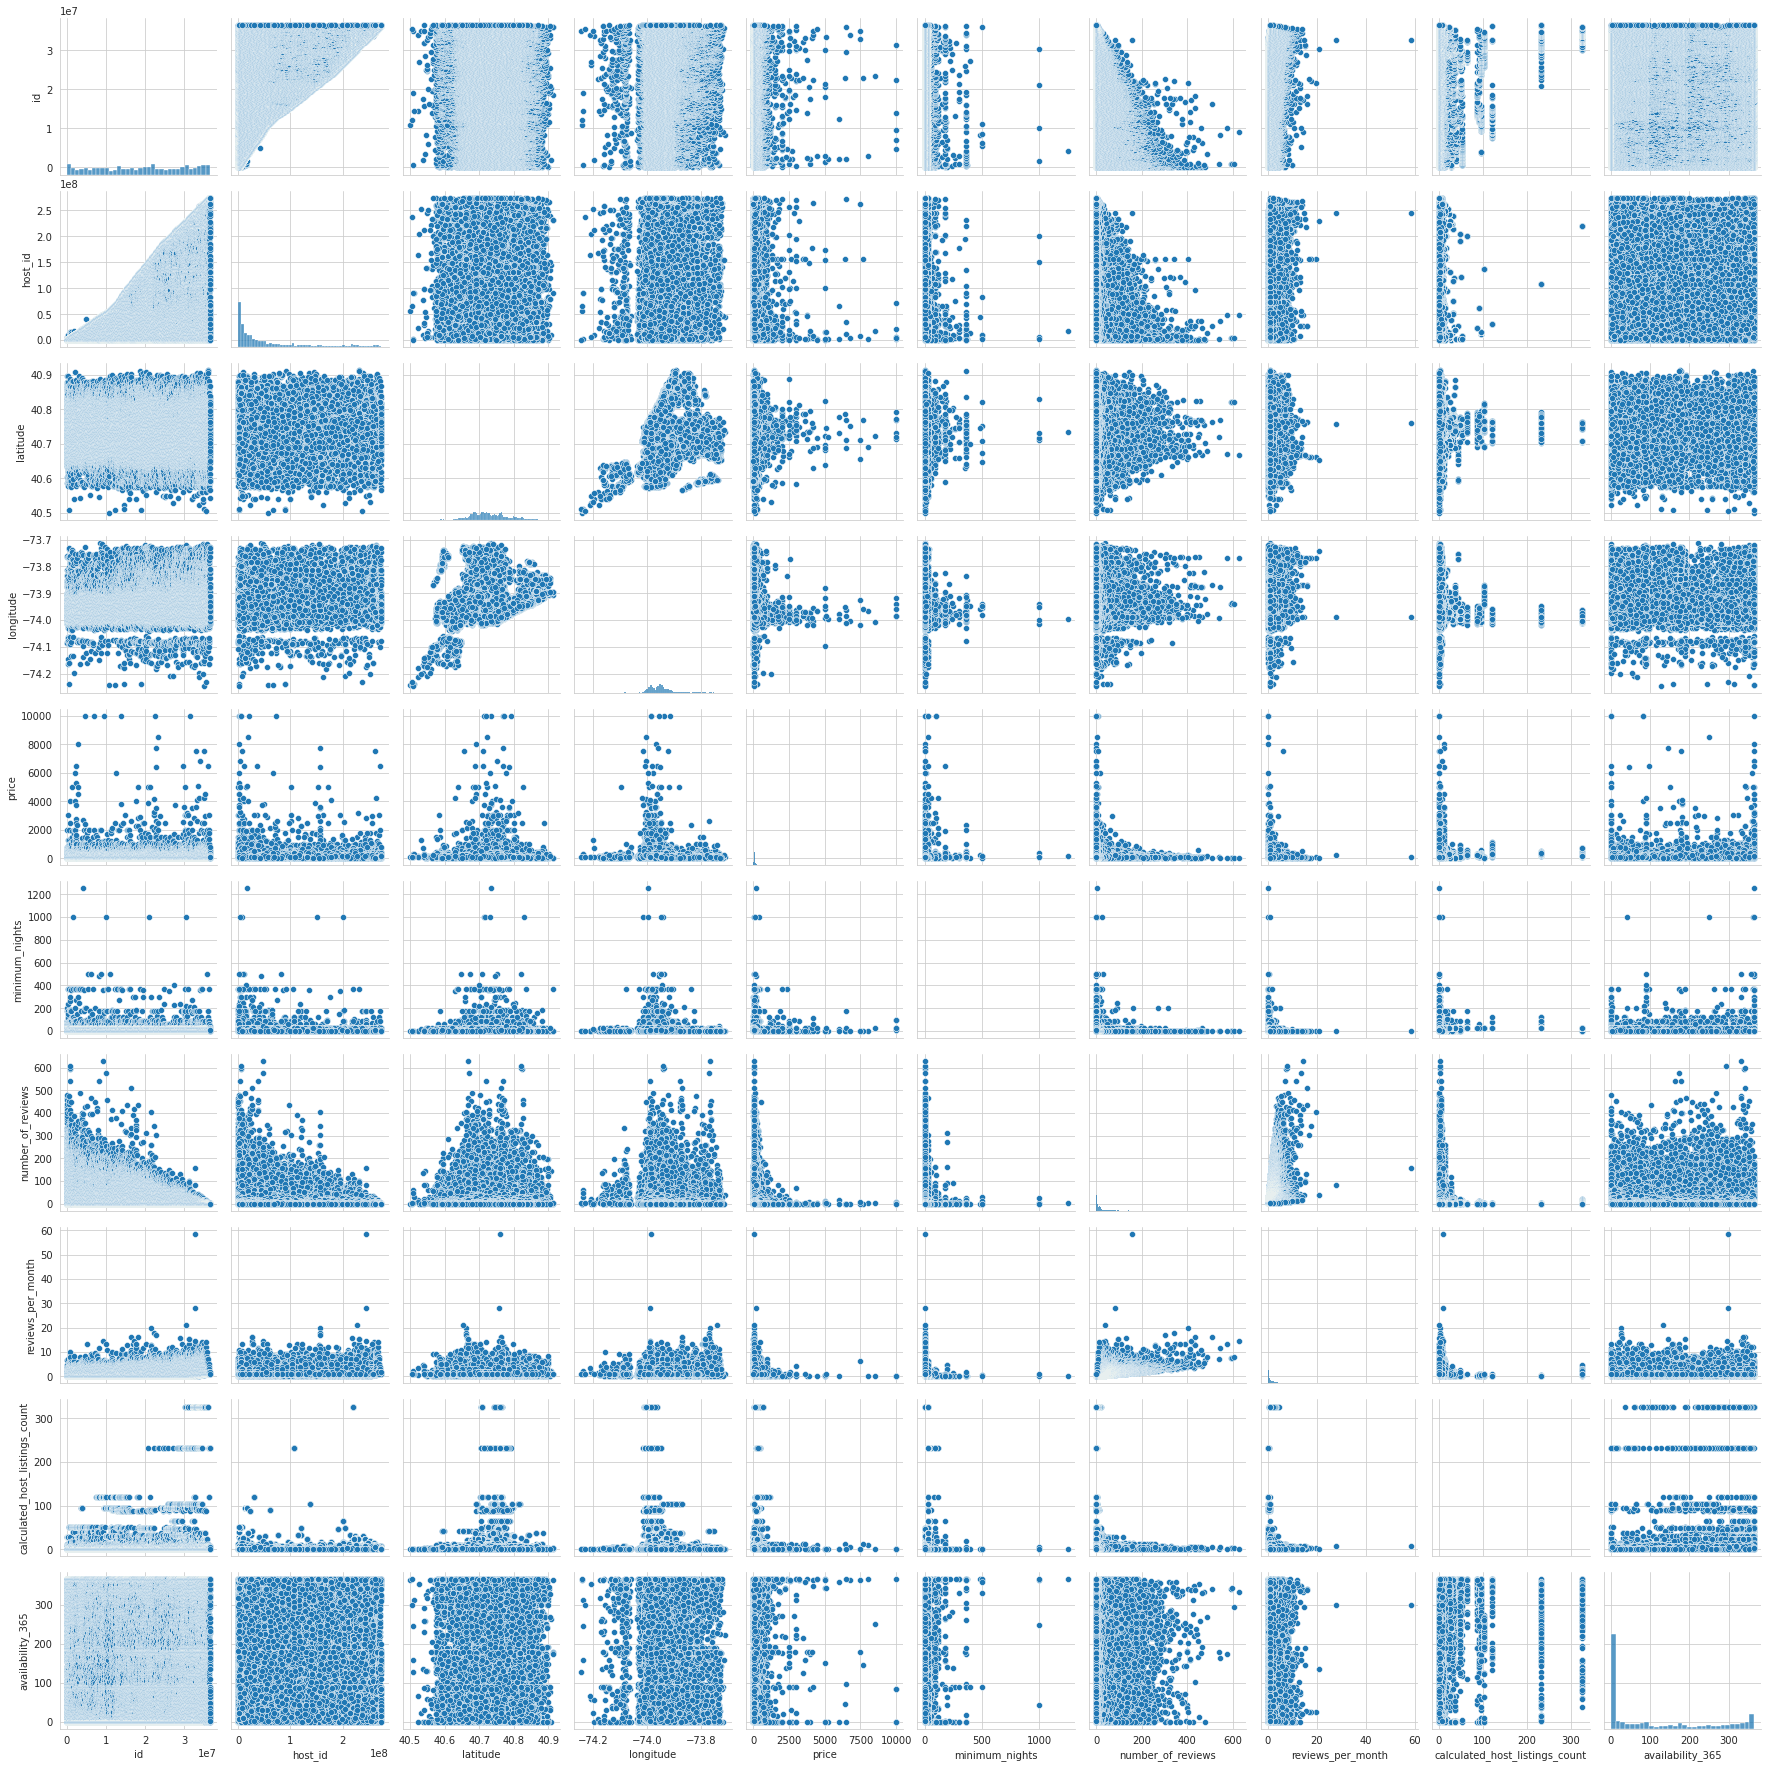

In [ ]:
sns.pairplot(df)
plt.show()

### Number of Listings by Boroughs

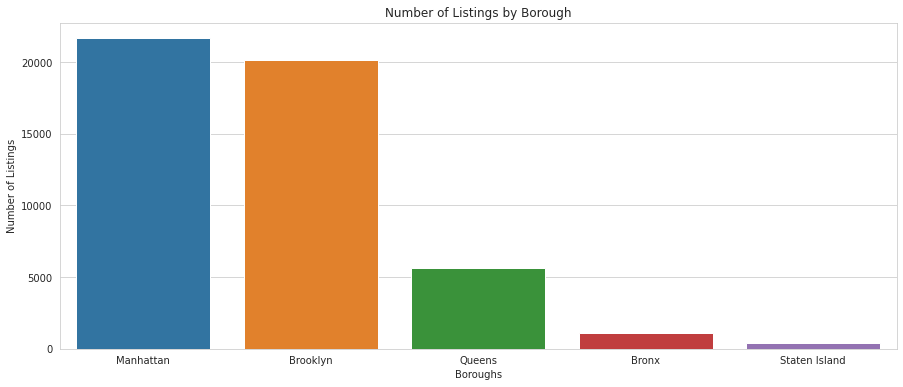

In [ ]:
nh= df['neighbourhood_group'].value_counts().reset_index()

plt.figure(figsize=(15,6))
sns.barplot(x = nh['index'],y = nh['neighbourhood_group']);
plt.ylabel("Number of Listings")
plt.xlabel("Boroughs")
plt.title('Number of Listings by Borough');
plt.show()

It is clear that maximum number of listings are present in Manhattan and Brooklynn.

### Number of Listing by Room Type

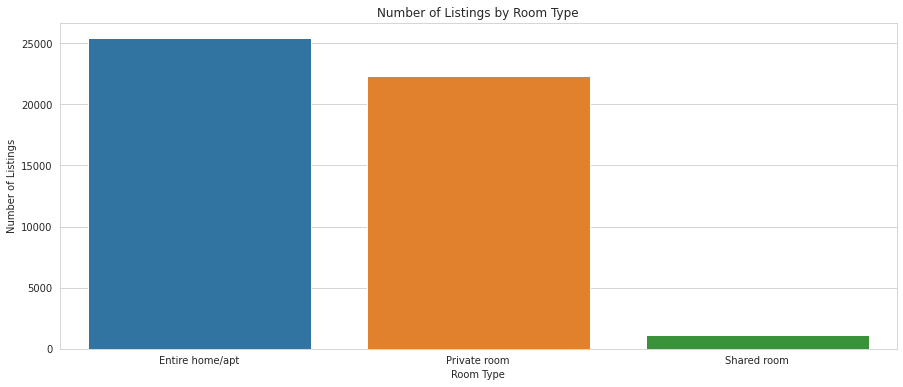

In [ ]:
nh= df['room_type'].value_counts().reset_index()

plt.figure(figsize=(15,6))
sns.barplot(x=nh['index'],y=nh['room_type'])
plt.ylabel("Number of Listings")
plt.xlabel("Room Type")
plt.title('Number of Listings by Room Type')
plt.show()

It is seen that maximum number of listings are for Entire Home/Apartments

### Number of Listing by Room Type and Borough

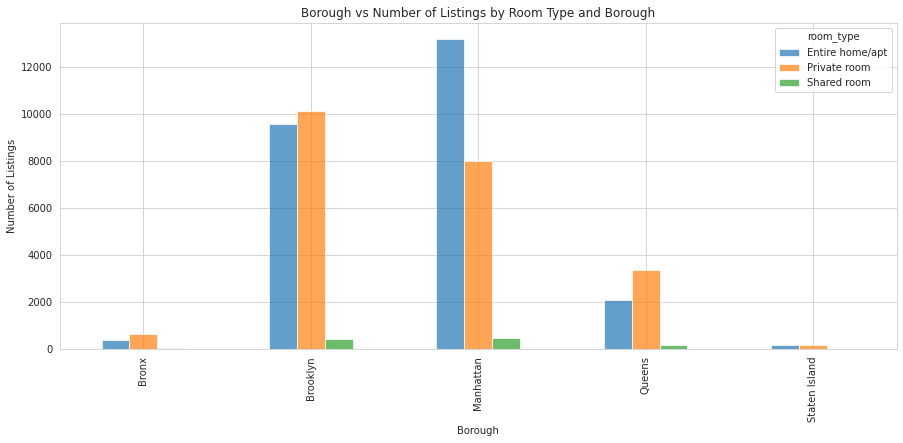

In [ ]:
nh = df.groupby(['neighbourhood_group','room_type'])['id'].count().reset_index()
nhg = nh.pivot(index='neighbourhood_group',columns='room_type',values='id')
nhg.plot(kind='bar',figsize=(15,6),style="g",alpha=0.7);
plt.title('Borough vs Number of Listings by Room Type and Borough')
plt.ylabel('Number of Listings')
plt.xlabel('Borough')
plt.show()

It is seen that Manhattan has the maximum number of Entire homes/apartments

Brooklyn has more Private Rooms than Apartments

### Borough Price Distribution

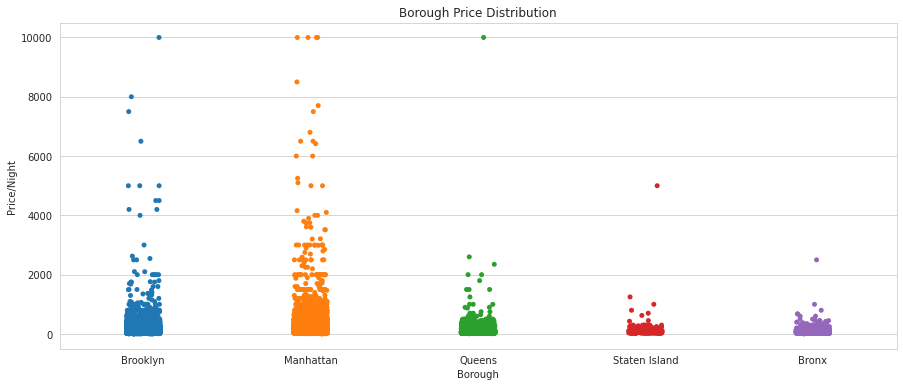

In [ ]:
plt.figure(figsize=(15,6))
sns.stripplot(x="neighbourhood_group",y="price",data=df)
plt.title('Borough Price Distribution')
plt.xlabel('Borough')
plt.ylabel('Price/Night')
plt.show()

The above grapph shows that most of the high priced listings are present in Manhattan and Brooklyn.

The listings in Staten Island and Bronx do not go over $4000/night

### Room Type Price Distribution

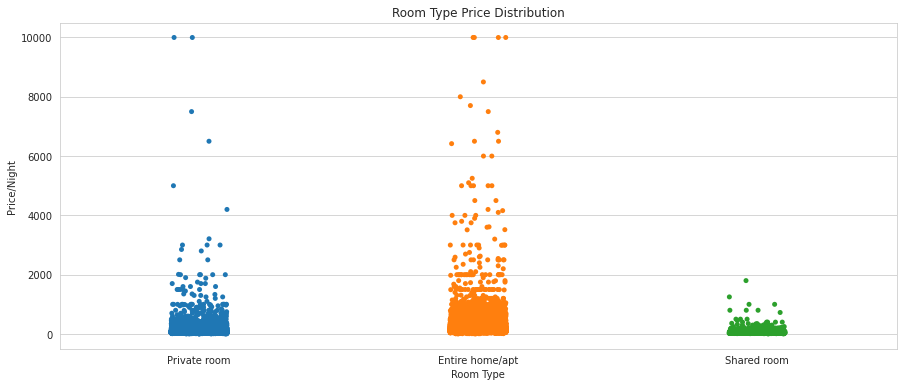

In [ ]:
plt.figure(figsize=(15,6))
sns.stripplot(x="room_type",y="price",data=df)
plt.title('Room Type Price Distribution')
plt.xlabel('Room Type')
plt.ylabel('Price/Night')
plt.show()

It is seen that most of the listings are priced under $2000/night 


### Room Type Availability

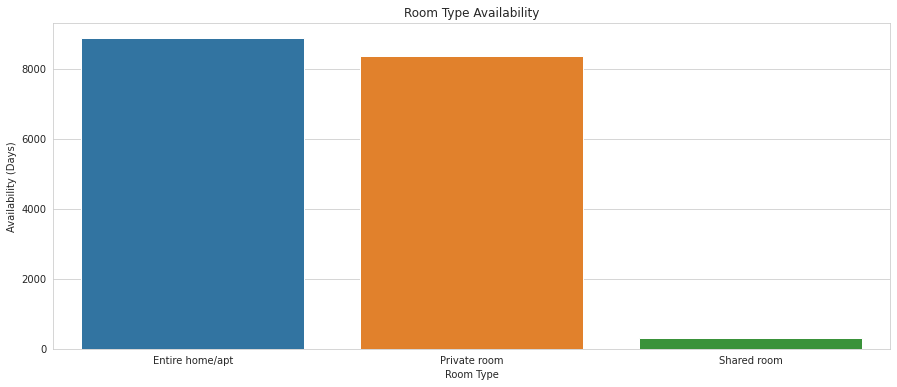

In [ ]:
aval= df.loc[df['availability_365'] == 0]['room_type'].value_counts().reset_index()

plt.figure(figsize=(15, 6))
sns.barplot(x="index",y="room_type",data=aval);
plt.title('Room Type Availability')
plt.ylabel('Availability (Days)')
plt.xlabel('Room Type')
plt.show()

The graph shows that Entire homes/Apartments and Private Rooms have a high availability.

### Top 10 Hosts with Highest Number of Listings

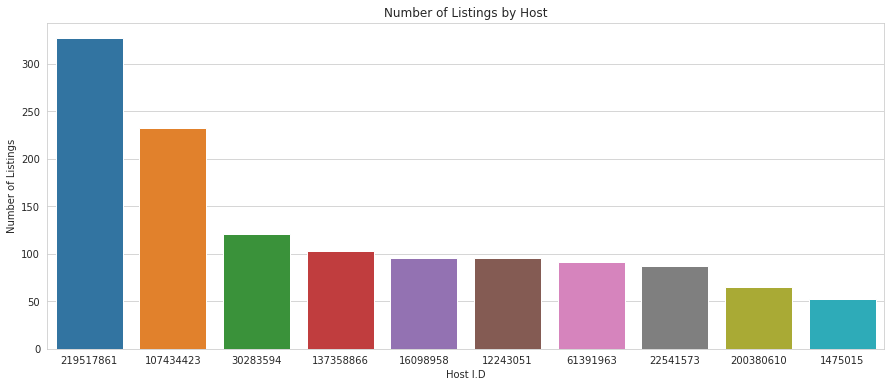

In [ ]:
host = df.groupby("host_id").count().reset_index()
host = host.sort_values("id",ascending=False).head(10)


plt.figure(figsize=(15,6))
sns.barplot(x="host_id",y="id",data=host,order=host.sort_values('id',ascending=False).host_id)
plt.ylabel("Number of Listings")
plt.xlabel("Host I.D")
plt.title('Number of Listings by Host')
plt.show()

The graph shows the 10 hosts with the highest number of listings

## DATA PREPROCESSING

In [ ]:
df.drop('id', axis=1, inplace=True)
df.drop('host_id', axis=1, inplace=True)
df.drop('name', axis=1, inplace=True)
df.drop('host_name', axis=1, inplace=True)

In [ ]:
df['reviews_per_month'].fillna(value=0, inplace=True)
df.drop('last_review',axis=1,inplace=True)

In [ ]:
df.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [ ]:
df.drop(df[df['price']==0].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
labelencoder = LabelEncoder()
df['neighbourhood'] = labelencoder.fit_transform(df['neighbourhood'])
df['neighbourhood_group'] = labelencoder.fit_transform(df['neighbourhood_group'])


df = pd.get_dummies(df)


df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,1,108,40.64749,-73.97237,149,1,9,0.21,6,365,0,1,0
1,2,127,40.75362,-73.98377,225,1,45,0.38,2,355,1,0,0
2,2,94,40.80902,-73.94190,150,3,0,0.00,1,365,0,1,0
3,1,41,40.68514,-73.95976,89,1,270,4.64,1,194,1,0,0
4,2,61,40.79851,-73.94399,80,10,9,0.10,1,0,1,0,0


## OUTLIER DETECTION

In [ ]:
def tukey_outliers(df, column):
  Q1 = np.percentile(df[column], 25)
  Q3 = np.percentile(df[column], 75)
  IQR = Q3 - Q1
  outlier_step = 1.5 * IQR
  outliers_index = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)].index
  return outliers_index


outliers_index = tukey_outliers(df,'price')
df.drop(outliers_index, inplace=True)
df.reset_index(drop=True, inplace=True)

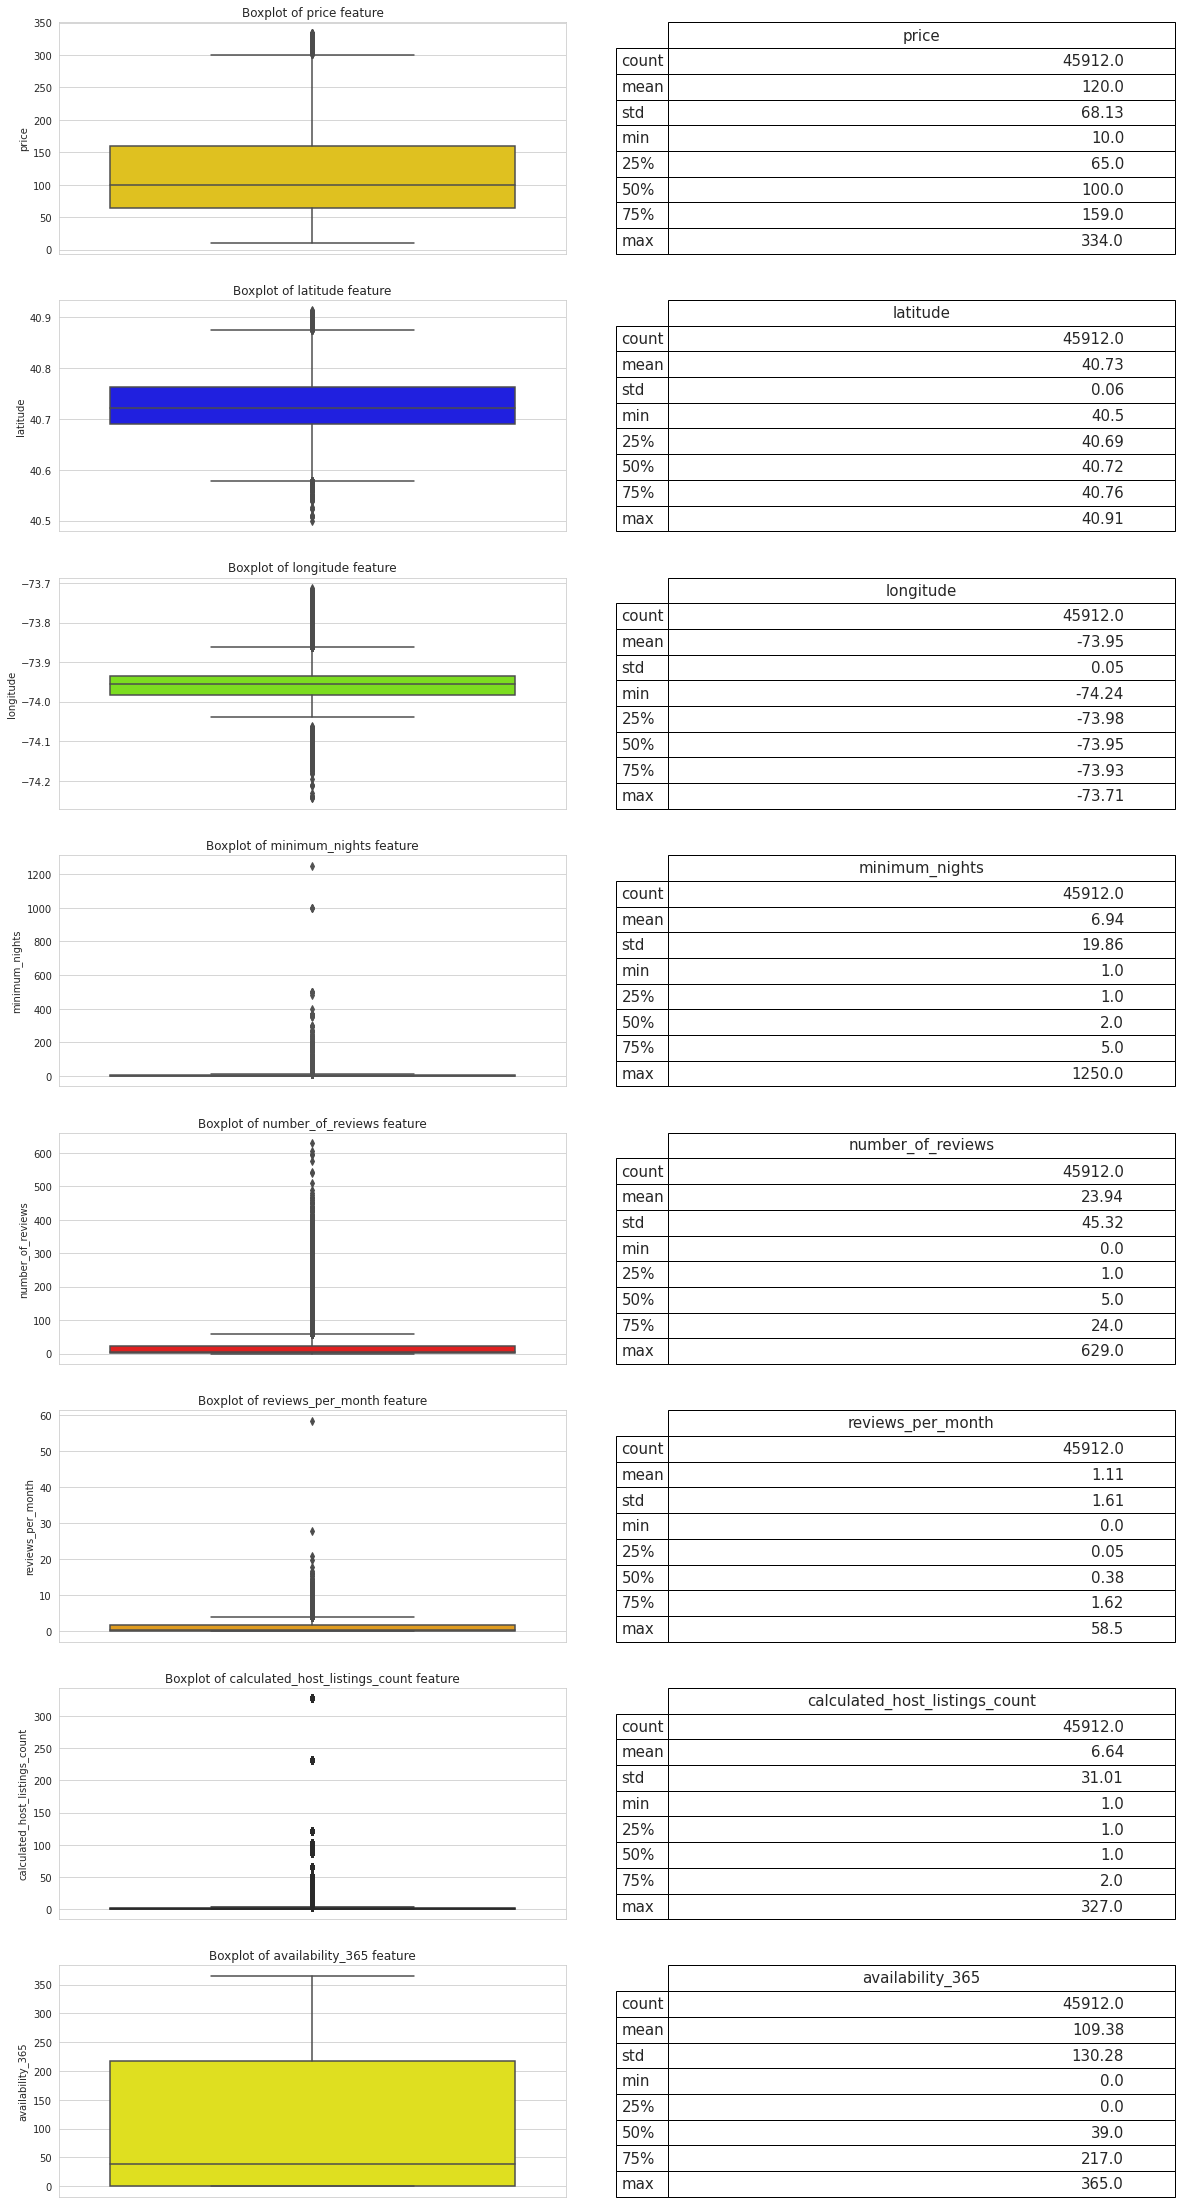

In [ ]:
dists = df[['price','latitude', 'longitude', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365']]

fig, ax = plt.subplots(8,2,figsize=(20,40))
bbox = [0, 0, 1, 1]
font_size = 15
colors = ['gold','blue','lawngreen','deeppink','red','orange','darkcyan','yellow']

for i in range(len(dists.columns)):
    describe = df[dists.columns[i]].describe().to_frame().round(2)
    sns.boxplot(y=df[dists.columns[i]],ax=ax[i][0], color=colors[i])
    table = ax[i][1].table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
    table.set_fontsize(font_size)
    ax[i][1].axis('off')
    ax[i][0].title.set_text('Boxplot of {} feature'.format(dists.columns[i]))



plt.show()

In [ ]:
pt = PowerTransformer(method='yeo-johnson')

df['price'],price_lambda = boxcox(df['price'])
print('"price lambda": {}'.format(price_lambda))


df['minimum_nights'],lam = boxcox(df['minimum_nights'])


df['calculated_host_listings_count'],lam = boxcox(df['calculated_host_listings_count'])


values = df['number_of_reviews'].values
df1 = pd.DataFrame({'x':values})
pt.fit(df1)
print(pt.lambdas_)


df['number_of_reviews']= boxcox1p(df['number_of_reviews'],pt.lambdas_)
print('"number_of_reviews lambda: {}"'.format(pt.lambdas_))


values = df['reviews_per_month'].values
df2 = pd.DataFrame({'x':values})
pt.fit(df2)
print(pt.lambdas_)


df['reviews_per_month']= boxcox1p(df['reviews_per_month'],pt.lambdas_)
print('"reviews_per_month lambda: {}"'.format(pt.lambdas_))


values = df['availability_365'].values
df3 = pd.DataFrame({'x':values})
pt.fit(df3)
print(pt.lambdas_)


df['availability_365']= boxcox1p(df['availability_365'],-1.84047863)
print('"availability_365 lambda: {}"'.format(pt.lambdas_))

"price lambda": 0.08383467575305965
"minimum_nights lambda": -0.4644546982027765
calculated_host_listings_count: -1.322615384279007
[-0.12794738]
"number_of_reviews lambda: [-0.12794738]"
[-1.04774384]
"reviews_per_month lambda: [-1.04774384]"
[0.06779621]
"availability_365 lambda: [0.06779621]"


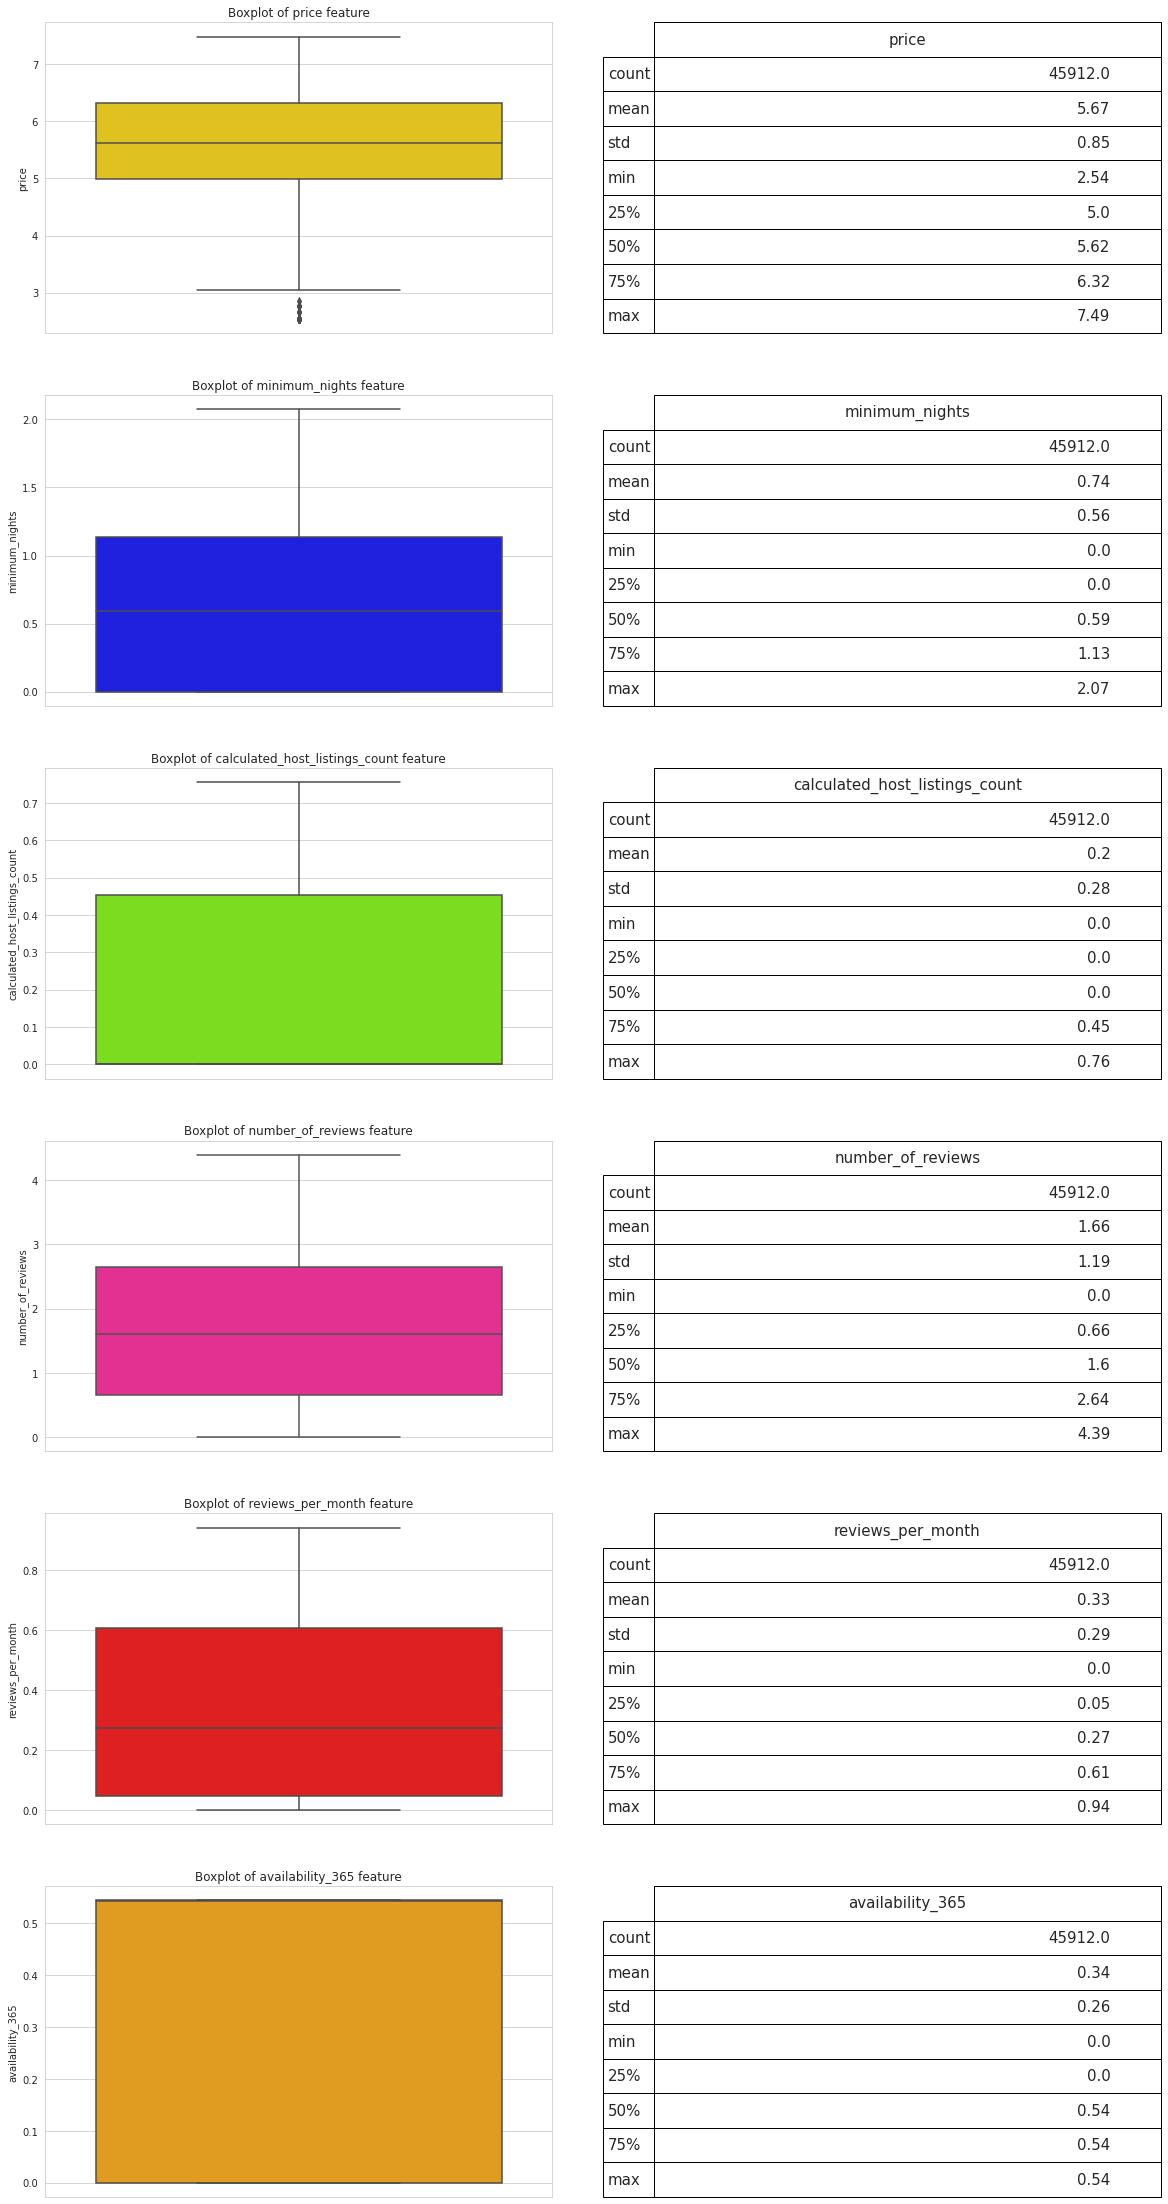

In [ ]:
dists = df[['price', 'minimum_nights',
       'calculated_host_listings_count','number_of_reviews','reviews_per_month','availability_365']]

fig, ax = plt.subplots(6,2,figsize=(20,40))
bbox = [0, 0, 1, 1]
font_size = 15
colors = ['gold','blue','lawngreen','deeppink','red','orange','darkcyan','yellow']

for i in range(len(dists.columns)):
    describe = df[dists.columns[i]].describe().to_frame().round(2)
    sns.boxplot(y=df[dists.columns[i]],ax=ax[i][0], color=colors[i])
    table = ax[i][1].table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
    table.set_fontsize(font_size)
    ax[i][1].axis('off')
    ax[i][0].title.set_text('Boxplot of {} feature'.format(dists.columns[i]))



plt.show()

## TRAIN TEST SPLIT

In [ ]:
target = df['price']
df.drop('price', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = .2, random_state=42)


print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (36729, 12)
Dimensions of the training target vector: (36729,)
Dimensions of the test feature matrix: (9183, 12)
Dimensions of the test target vector: (9183,)


## PREDICTIVE MODELS

In [ ]:
n_folds = 5

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 64).get_n_splits(df)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [ ]:
def rmse(actual,predicted):
    return(np.sqrt(mean_squared_error(actual, predicted)))

def model_scores(model, cv_model, y_train, y_test, pred_train, pred_test):
    mse = mean_squared_error(y_test, lin_reg_pred_test)
    results = pd.DataFrame({'Model':['{}'.format(type(model).__name__)],
                'CV error': '{:.3f}'.format(cv_model.mean()), 
                'CV std': '{:.3f}'.format(cv_model.std()),
                'RMSE train': [rmse(y_train, pred_train)],
                'RMSE test': [rmse(y_test, pred_test)],
                'MAE train': [mean_absolute_error(y_train, pred_train)],
                'MAE test': [mean_absolute_error(y_test, pred_test)],
                'R2 train': [r2_score(y_train, pred_train)],
                'R2 test': [r2_score(y_test, pred_test)],})
    results = results.round(decimals=4)

    return results

### LINEAR REGRESSION

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

lin_reg_cv = rmse_cv(LinearRegression())
lin_reg_pred_train = lin_reg.predict(X_train)
lin_reg_pred_test = lin_reg.predict(X_test)

lin_reg_results = model_scores(lin_reg, lin_reg_cv, y_train, y_test, lin_reg_pred_train, lin_reg_pred_test)

lin_reg_results.style.hide_index()


Model,CV error,CV std,RMSE train,RMSE test,MAE train,MAE test,R2 train,R2 test
LinearRegression,-0.345,0.005,0.587400,0.588700,0.458500,0.460900,0.526700,0.514200


### SUPPORT VECTOR MACHINE

In [ ]:
svm_reg = SVR()
svm_reg.fit(X_train, y_train)

svm_reg_cv = rmse_cv(SVR())
svm_reg_pred_train = svm_reg.predict(X_train)
svm_reg_pred_test = svm_reg.predict(X_test)

svm_reg_results = model_scores(svm_reg, svm_reg_cv, y_train, y_test, svm_reg_pred_train, svm_reg_pred_test)

svm_reg_results.style.hide_index()

Model,CV error,CV std,RMSE train,RMSE test,MAE train,MAE test,R2 train,R2 test
SVR,-0.474,0.012,0.676800,0.670000,0.543200,0.536300,0.371600,0.370900


### DECISION TREE

In [ ]:
dtr_reg = DecisionTreeRegressor()
dtr_reg.fit(X_train, y_train)

dtr_reg_cv = rmse_cv(DecisionTreeRegressor())
dtr_reg_pred_train = dtr_reg.predict(X_train)
dtr_reg_pred_test = dtr_reg.predict(X_test)

dtr_reg_results = model_scores(dtr_reg, dtr_reg_cv, y_train, y_test, dtr_reg_pred_train, dtr_reg_pred_test)

dtr_reg_results.style.hide_index()

Model,CV error,CV std,RMSE train,RMSE test,MAE train,MAE test,R2 train,R2 test
DecisionTreeRegressor,-0.516,0.011,0.001900,0.710900,0.000000,0.533300,1.000000,0.291700


### RANDOM FOREST

In [ ]:
rfr_reg = RandomForestRegressor(random_state=42)
rfr_reg.fit(X_train, y_train) 

rfr_reg_cv = rmse_cv(RandomForestRegressor())
rfr_pred_train = rfr_reg.predict(X_train)
rfr_pred_test = rfr_reg.predict(X_test)

rfr_reg_results = model_scores(rfr_reg, rfr_reg_cv, y_train, y_test, rfr_pred_train, rfr_pred_test)

rfr_reg_results.style.hide_index()

Model,CV error,CV std,RMSE train,RMSE test,MAE train,MAE test,R2 train,R2 test
RandomForestRegressor,-0.264,0.006,0.191300,0.510800,0.144400,0.388400,0.949800,0.634300


### ADA BOOSTER

In [ ]:
ada_reg = AdaBoostRegressor()
ada_reg.fit(X_train, y_train)

ada_reg_cv = rmse_cv(AdaBoostRegressor())
ada_reg_pred_train = ada_reg.predict(X_train)
ada_reg_pred_test = ada_reg.predict(X_test)

ada_reg_results = model_scores(ada_reg, ada_reg_cv, y_train, y_test, ada_reg_pred_train, ada_reg_pred_test)

ada_reg_results.style.hide_index()

Model,CV error,CV std,RMSE train,RMSE test,MAE train,MAE test,R2 train,R2 test
AdaBoostRegressor,-0.348,0.010,0.580100,0.577800,0.457200,0.454200,0.538400,0.532100


### GRADIENT BOOSTER

In [ ]:
gbr_reg = GradientBoostingRegressor()
gbr_reg.fit(X_train, y_train)

gbr_reg_cv = rmse_cv(GradientBoostingRegressor())
gbr_reg_pred_train = gbr_reg.predict(X_train)
gbr_reg_pred_test = gbr_reg.predict(X_test)

gbr_reg_results = model_scores(gbr_reg, gbr_reg_cv, y_train, y_test, gbr_reg_pred_train, gbr_reg_pred_test)

gbr_reg_results.style.hide_index()

Model,CV error,CV std,RMSE train,RMSE test,MAE train,MAE test,R2 train,R2 test
GradientBoostingRegressor,-0.270,0.005,0.513700,0.519600,0.397300,0.401300,0.637900,0.621600


### XGB BOOSTER

In [ ]:
xgb_reg = XGBRegressor(n_estimators=1000)
xgb_reg.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

xgb_reg = XGBRegressor(learning_rate=0.3,
                      n_estimators=1000,
                      max_depth=6, min_child_weight=1)

xgb_reg_cv = rmse_cv(xgb_reg)

xgb_reg.fit(X_train, y_train)
xgb_pred_train = xgb_reg.predict(X_train)
xgb_pred_test = xgb_reg.predict(X_test)

xgb_reg_results = model_scores(xgb_reg, xgb_reg_cv, y_train, y_test, xgb_pred_train, xgb_pred_test)

xgb_reg_results.style.hide_index()

[08:08:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Model,CV error,CV std,RMSE train,RMSE test,MAE train,MAE test,R2 train,R2 test
XGBRegressor,-0.287,0.005,0.306100,0.524600,0.225900,0.400600,0.871500,0.614400


## MODEL EVALUATION

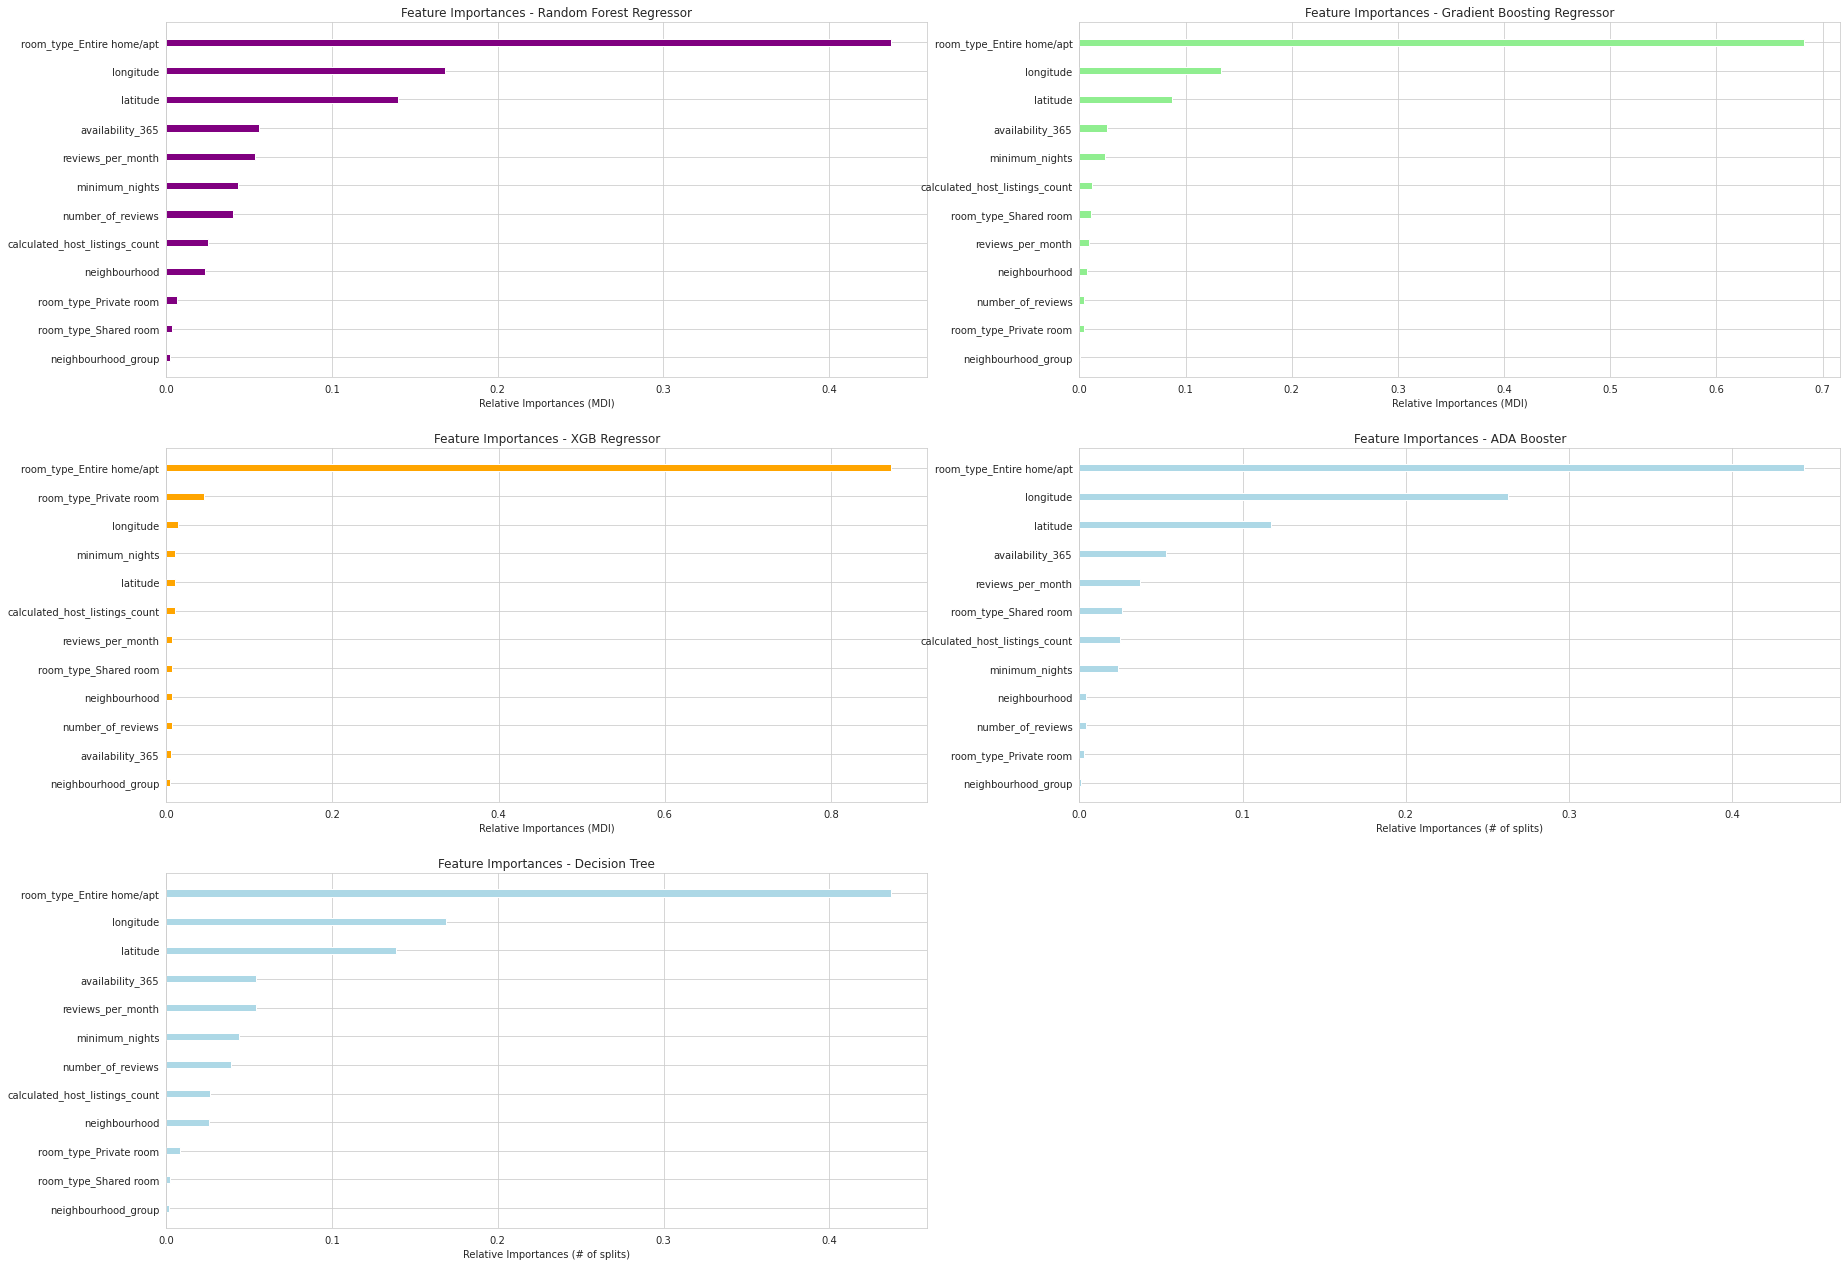

In [ ]:
plt.figure(figsize=(30, 30))

plt.subplot(4,2,1)
importances_RF = rfr_reg.feature_importances_
indices_RF = np.argsort(importances_RF)

plt.title('Feature Importances - Random Forest Regressor')
plt.barh(df.columns, importances_RF[indices_RF], .25, color='purple')
plt.yticks(df.columns, df.columns[indices_RF])
plt.xlabel('Relative Importances (MDI)')

plt.subplot(4,2,2)
importances_GB = gbr_reg.feature_importances_
indices_GB = np.argsort(importances_GB)

plt.title('Feature Importances - Gradient Boosting Regressor')
plt.barh(df.columns, importances_GB[indices_GB], .25, color='lightgreen')
plt.yticks(df.columns, df.columns[indices_GB])
plt.xlabel('Relative Importances (MDI)')

plt.subplot(4,2,3)
importances_XGB = xgb_reg.feature_importances_
indices_XGB = np.argsort(importances_XGB)

plt.title('Feature Importances - XGB Regressor')
plt.barh(df.columns, importances_XGB[indices_XGB], .25, color='orange')
plt.yticks(df.columns, df.columns[indices_XGB])
plt.xlabel('Relative Importances (MDI)')

plt.subplot(4,2,4)
importances_ADA = ada_reg.feature_importances_
indices_ADA = np.argsort(importances_ADA)

plt.title('Feature Importances - ADA Booster')
plt.barh(df.columns, importances_ADA[indices_ADA], .25, color='lightblue')
plt.yticks(df.columns, df.columns[indices_ADA])
plt.xlabel('Relative Importances (# of splits)')

plt.subplot(4,2,5)
importances_dtr = dtr_reg.feature_importances_
indices_dtr = np.argsort(importances_dtr)

plt.title('Feature Importances - Decision Tree')
plt.barh(df.columns, importances_dtr[indices_dtr], .25, color='lightblue')
plt.yticks(df.columns, df.columns[indices_dtr])
plt.xlabel('Relative Importances (# of splits)')

plt.show()

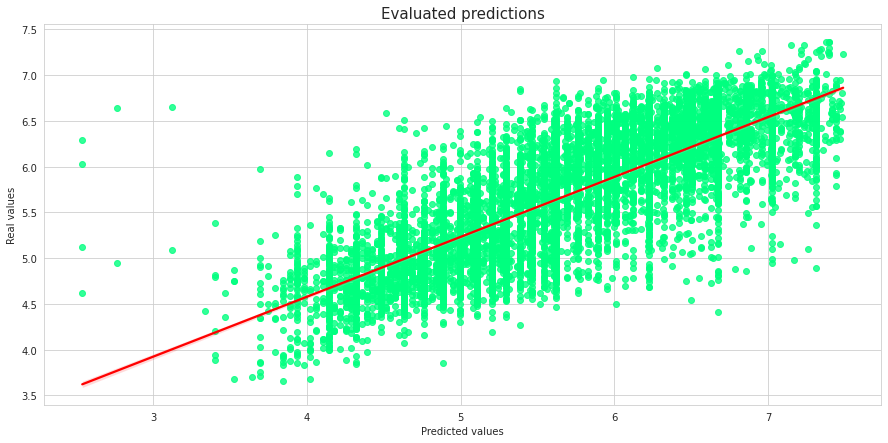

In [ ]:
plt.figure(figsize=(15,7))
sns.regplot(y=rfr_pred_test, x=y_test, line_kws={"color": "red"}, color='springgreen')
plt.title('Evaluated predictions', fontsize=15)
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.show()

## CONCLUSION:

*   Maximum number of Listings are available in Manhattan and Brooklyn
*   Entire Homes/Apartments are the highest listed room types followed by Private Room
*   Most of the listings are available under 2000 dollars per night
*   The more expensive rooms ($4000 and above) are only available in Manhattan and Brooklyn
*   Almost all the listings have 365 day availability





